In [1]:
!mkdir -p data/uber_raw
!unzip -j "*.zip" uber-raw-data-apr14.csv uber-raw-data-may14.csv uber-raw-data-jun14.csv uber-raw-data-jul14.csv uber-raw-data-aug14.csv uber-raw-data-sep14.csv -d data/uber_raw

Archive:  uber-raw-data-aug14.csv.zip
  inflating: data/uber_raw/uber-raw-data-aug14.csv  
caution: filename not matched:  uber-raw-data-apr14.csv
caution: filename not matched:  uber-raw-data-may14.csv
caution: filename not matched:  uber-raw-data-jun14.csv
caution: filename not matched:  uber-raw-data-jul14.csv
caution: filename not matched:  uber-raw-data-sep14.csv

Archive:  uber-raw-data-may14.csv.zip
  inflating: data/uber_raw/uber-raw-data-may14.csv  
caution: filename not matched:  uber-raw-data-apr14.csv
caution: filename not matched:  uber-raw-data-jun14.csv
caution: filename not matched:  uber-raw-data-jul14.csv
caution: filename not matched:  uber-raw-data-aug14.csv
caution: filename not matched:  uber-raw-data-sep14.csv

Archive:  uber-raw-data-sep14.csv.zip
  inflating: data/uber_raw/uber-raw-data-sep14.csv  
caution: filename not matched:  uber-raw-data-apr14.csv
caution: filename not matched:  uber-raw-data-may14.csv
caution: filename not matched:  uber-raw-data-jun14.c

In [2]:
!pip install h3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.8 MB/s eta 0:00:00


In [19]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import h3
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import folium
from folium import Map, CircleMarker, GeoJson
from folium.plugins import HeatMap
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

In [4]:
CONS_HEX_RESOLUTION = 7

In [5]:
# 1) List the six filenames (in the order Apr → Sep)
months = ["apr14", "may14", "jun14"]
base_path = "data/uber_raw"  # adjust as needed

dfs = []
for m in months:
    fname = f"uber-raw-data-{m}.csv"
    path = os.path.join(base_path, fname)
    # read CSV, parse Date/Time, keep only the four columns
    df = pd.read_csv(
        path,
        usecols=["Date/Time", "Lat", "Lon", "Base"],
        parse_dates=["Date/Time"],
        infer_datetime_format=True,
    )
    dfs.append(df)

# 2) Concatenate into one DataFrame
full_df = pd.concat(dfs, ignore_index=True)

## DATA WRANGLING

In [6]:
# Author: Jhonathan Pauca
# Scope: Classes: TimestampProcessor, SpatialIndexer, Aggregator, FeatureEngineer, SpatialPreprocessor, AnomalyDetector, Visualizer, Evaluator.
# Organization: Universidad Nacional Mayor de  San Marcos
# Course: Machine Learning and Big Data
# Professor: Víctor Cabrejos
# Description: Anomaly Detection on Uber's Trips in New York City in 2014.
class TimestampProcessor:
    """Handle timestamp processing."""
    def __init__(self, datetime_col: str = 'timestamp'):
        self.datetime_col = datetime_col

    def floor_to_hour(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df[self.datetime_col] = pd.to_datetime(df[self.datetime_col])
        df['timestamp_hour'] = df[self.datetime_col].dt.floor('H')
        return df


class SpatialIndexer:
    """Assign H3 indices and compute centroids."""
    def __init__(self, lat_col: str = 'lat', lon_col: str = 'lon', resolution: int = 7):
        self.lat_col = lat_col
        self.lon_col = lon_col
        self.resolution = resolution

    def add_h3_index(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        # Compute H3 index for each row
        df['h3_index'] = df.apply(lambda row: h3.latlng_to_cell(row[self.lat_col], row[self.lon_col], self.resolution), axis=1)
        return df

    def compute_centroids(self, h3_indexes: pd.Series) -> pd.DataFrame:
        # Given a Series of unique H3 indexes, return DataFrame with h3_index, centroid_lat, centroid_lon
        centroids = []
        for idx in h3_indexes:
            lat, lon = h3.cell_to_latlng(idx)
            centroids.append({'h3_index': idx, 'centroid_lat': lat, 'centroid_lon': lon})
        return pd.DataFrame(centroids)


class Aggregator:
    """Aggregate counts per hour and H3 cell."""
    def __init__(self, time_col: str = 'timestamp_hour', h3_col: str = 'h3_index', value_col: str = 'value'):
        self.time_col = time_col
        self.h3_col = h3_col
        self.value_col = value_col

    def aggregate_hourly(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df[self.time_col] = pd.to_datetime(df[self.time_col])
        agg = df.groupby([self.time_col, self.h3_col]).agg(
            **{self.value_col: (self.h3_col, 'count')}
        ).reset_index().rename(columns={self.time_col: 'timestamp'})
        # Ensure full combinations for observed hours and cells
        all_hours = pd.date_range(start=agg['timestamp'].min(), end=agg['timestamp'].max(), freq='H')
        all_cells = agg[self.h3_col].unique()
        mi = pd.MultiIndex.from_product([all_hours, all_cells], names=['timestamp', self.h3_col])
        full = pd.DataFrame(index=mi).reset_index()
        full = full.merge(agg, how='left', on=['timestamp', self.h3_col])
        full[self.value_col] = full[self.value_col].fillna(0)
        return full


class FeatureEngineer:
    """Add time features, lags, and rolling stats."""
    def __init__(self, rolling_window: int = 24, time_col: str = 'timestamp', value_col: str = 'value', group_col: str = 'h3_index'):
        self.rolling_window = rolling_window
        self.time_col = time_col
        self.value_col = value_col
        self.group_col = group_col

    def add_time_features(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['Weekday'] = df[self.time_col].dt.day_name()
        df['Hour'] = df[self.time_col].dt.hour
        df['Day'] = df[self.time_col].dt.dayofweek
        df['Month_day'] = df[self.time_col].dt.day
        df['Month'] = df[self.time_col].dt.month
        df['Year'] = df[self.time_col].dt.year
        return df

    def add_lag_and_rolling(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df = df.sort_values([self.group_col, self.time_col])
        df['Lag'] = df.groupby(self.group_col)[self.value_col].shift(1).fillna(0)
        df['Rolling_Mean'] = (
            df.groupby(self.group_col)[self.value_col]
            .rolling(window=self.rolling_window, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
        return df

    def add_cyclic_features(self, df: pd.DataFrame, drop_original: bool = True) -> pd.DataFrame:
      """Encodes cyclic time features (hour, day of week, month)."""
      df_encoded = df.copy()
      # Ensure timestamp is datetime
      df_encoded[self.time_col] = pd.to_datetime(df_encoded[self.time_col])
      ts = df_encoded[self.time_col].dt

      df_encoded['hour_sin'] = np.sin(2 * np.pi * ts.hour / 24)
      df_encoded['hour_cos'] = np.cos(2 * np.pi * ts.hour / 24)
      df_encoded['dow_sin'] = np.sin(2 * np.pi * ts.dayofweek / 7)
      df_encoded['dow_cos'] = np.cos(2 * np.pi * ts.dayofweek / 7)
      df_encoded['month_sin'] = np.sin(2 * np.pi * (ts.month - 1) / 12)
      df_encoded['month_cos'] = np.cos(2 * np.pi * (ts.month - 1) / 12)

      if drop_original:
          cols_to_drop = ['Hour', 'Day', 'Month_day', 'Month']
          for col in cols_to_drop:
              if col in df_encoded.columns:
                  df_encoded = df_encoded.drop(columns=[col])

      return df_encoded

class SpatialPreprocessor:
    """Prepare spatial features for anomaly detection."""
    def __init__(self, lat_col: str = 'lat', lon_col: str = 'lon'):
        self.lat_col = lat_col
        self.lon_col = lon_col
        self.scaler = None
        self.mean_lat = None
        self.mean_lon = None

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        # Compute means for centering
        self.mean_lat = df[self.lat_col].mean()
        self.mean_lon = df[self.lon_col].mean()
        # Convert to planar meters
        mean_lat_rad = np.deg2rad(self.mean_lat)
        lat_to_m = 110574
        lon_to_m = 111320 * np.cos(mean_lat_rad)
        df['x'] = (df[self.lon_col] - self.mean_lon) * lon_to_m
        df['y'] = (df[self.lat_col] - self.mean_lat) * lat_to_m
        self.scaler = StandardScaler()
        df[['x_scaled', 'y_scaled']] = self.scaler.fit_transform(df[['x', 'y']])
        return df

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        # Requires fit_transform called first
        if self.mean_lat is None or self.scaler is None:
            raise ValueError("SpatialPreprocessor not fitted. Call fit_transform first.")
        mean_lat_rad = np.deg2rad(self.mean_lat)
        lat_to_m = 110574
        lon_to_m = 111320 * np.cos(mean_lat_rad)
        df['x'] = (df[self.lon_col] - self.mean_lon) * lon_to_m
        df['y'] = (df[self.lat_col] - self.mean_lat) * lat_to_m
        df[['x_scaled', 'y_scaled']] = self.scaler.transform(df[['x', 'y']])
        return df

    def compute_local_density(self, df: pd.DataFrame, n_neighbors: int = 5) -> pd.Series:
        coords = df[['x_scaled', 'y_scaled']].values
        neigh = NearestNeighbors(n_neighbors=n_neighbors + 1)
        neigh.fit(coords)
        distances, _ = neigh.kneighbors(coords)
        kth_dist = distances[:, -1]
        eps = 1e-6
        density = 1.0 / (kth_dist + eps)
        return pd.Series(density, index=df.index)


class AnomalyDetector:
    """Detect anomalies using IsolationForest with spatial features."""
    def __init__(self, feature_cols: list, contamination: float = 0.1, n_estimators: int = 200, max_samples=0.7, use_density: bool = True, density_neighbors: int = 5, random_state: int = 42):
        self.feature_cols = feature_cols
        self.contamination = contamination
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.use_density = use_density
        self.density_neighbors = density_neighbors
        self.random_state = random_state
        self.spatial_preprocessor = SpatialPreprocessor(lat_col='centroid_lat', lon_col='centroid_lon')
        self.model = None
        self.evaluator = Evaluator()

    def fit(self, df: pd.DataFrame):
        df_proc = df.copy()
        # Ensure timestamp exists
        if 'timestamp' in df_proc.columns:
            df_proc['timestamp'] = pd.to_datetime(df_proc['timestamp'])
            df_proc = df_proc.sort_values('timestamp')
        else:
            df_proc = df_proc.sort_index().reset_index().rename(columns={'index': 'timestamp'})
            df_proc['timestamp'] = pd.to_datetime(df_proc['timestamp'])
        # Spatial preprocessing on centroids
        df_proc = self.spatial_preprocessor.fit_transform(df_proc)
        # Compute density
        if self.use_density:
            df_proc['local_density'] = self.spatial_preprocessor.compute_local_density(df_proc, n_neighbors=self.density_neighbors)
        else:
            df_proc['local_density'] = np.nan
        # Assemble features
        features = [col for col in self.feature_cols if col in df_proc.columns]
        features += ['x_scaled', 'y_scaled']
        if self.use_density:
            features.append('local_density')
        X = df_proc[features].fillna(0).values

        # Scale the features for Isolation Forest
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        self.model = IsolationForest(
            random_state=self.random_state,
            contamination=self.contamination,
            n_estimators=self.n_estimators,
            max_samples=self.max_samples,
            n_jobs=-1
        )
        self.model.fit(X_scaled) # Fit with scaled data
        # Store processed DataFrame and labels
        df_proc['is_anomaly'] = pd.Series(self.model.predict(X_scaled)).apply(lambda x: 1 if x == -1 else 0).values
        df_proc['anomaly_score'] = self.model.decision_function(X_scaled) # Calculate scores on scaled data

        # Calculate MV/EM curves using the Evaluator instance
        real_scores = -df_proc['anomaly_score'].values # Isolation Forest scores are negative for anomalies
        random_X = self.evaluator.sample_random_uniform(X_scaled, n_samples=5000, random_state=self.random_state) # Sample in scaled space
        random_scores = -self.model.decision_function(random_X) # Score random samples

        self.evaluator.approximate_mv_em_curves(real_scores, random_scores, n_thresholds=100) # Calculate and store MV/EM curves

        self.df_proc_ = df_proc
        return df_proc

    def get_results(self) -> dict:
        # Group by timestamp: collect lat/lon of centroids
        anomalous = {'time_index': [], 'data': []}
        non_anomalous = {'time_index': [], 'data': []}
        grouped = self.df_proc_.groupby('timestamp')
        for ts, group in grouped:
            coords = group[['centroid_lat', 'centroid_lon']].values.tolist()
            ts_str = ts.strftime("%Y-%m-%d %H:%M:%S")
            anom_rows = group[group['is_anomaly'] == 1]
            non_anom_rows = group[group['is_anomaly'] == 0]
            if len(anom_rows) > 0:
                anomalous['time_index'].append(ts_str)
                anomalous['data'].append(anom_rows[['centroid_lat', 'centroid_lon']].values.tolist())
            if len(non_anom_rows) > 0:
                non_anomalous['time_index'].append(ts_str)
                non_anomalous['data'].append(non_anom_rows[['centroid_lat', 'centroid_lon']].values.tolist())
        return {'anomalous': anomalous, 'non_anomalous': non_anomalous}


class Visualizer:
    """Single responsibility: interactive visualization for H3 aggregated data and anomalies, with heatmap for normals."""
    def __init__(self, df: pd.DataFrame, time_col: str = 'timestamp', h3_col: str = 'h3_index', value_col: str = 'value', anomaly_col: str = 'is_anomaly'):
        self.df = df.copy()
        self.time_col = time_col
        self.h3_col = h3_col
        self.value_col = value_col
        self.anomaly_col = anomaly_col
        self.df[self.time_col] = pd.to_datetime(self.df[self.time_col])
        self.df['timestamp_hour'] = self.df[self.time_col].dt.floor('H')
        self.df['date_only'] = self.df['timestamp_hour'].dt.date

    def interactive_hexmap(self, resolution: int = 7):
        """Interactive date/hour selection to display hex cell counts, heatmap for normals, and anomalies."""
        available_dates = sorted(self.df['date_only'].unique())
        if not available_dates:
            print("No timestamps available.")
            return
        start_date = min(available_dates)
        end_date = max(available_dates)
        date_picker = widgets.DatePicker(description='Select date', value=start_date, min=start_date, max=end_date)
        hour_slider = widgets.IntSlider(value=0, min=0, max=23, step=1, description='Hour', continuous_update=False)
        out = widgets.Output()

        def plot_for_selection(date, hour):
            ts = pd.Timestamp(date) + pd.Timedelta(hours=hour)
            df_sel = self.df[self.df['timestamp_hour'] == ts]
            with out:
                clear_output()
                if df_sel.empty:
                    print(f"No data for {ts}")
                    return
                center_lat = df_sel['centroid_lat'].mean() if 'centroid_lat' in df_sel.columns else df_sel['lat'].mean()
                center_lon = df_sel['centroid_lon'].mean() if 'centroid_lon' in df_sel.columns else df_sel['lon'].mean()
                m = Map(location=[center_lat, center_lon], zoom_start=12)
                # Draw hex polygons colored by count
                max_count = df_sel[self.value_col].max()
                for _, row in df_sel.iterrows():
                    hex_idx = row[self.h3_col]
                    count = row[self.value_col]
                    boundary_latlon = h3.cell_to_boundary(hex_idx)
                    boundary_geojson = [[lon, lat] for lat, lon in boundary_latlon]
                    opacity = count / max_count if max_count > 0 else 0
                    def style_func(feature, op=opacity):
                        return {'fillColor': 'red', 'color': 'gray', 'weight': 1, 'fillOpacity': op * 0.8}
                    # Prepare properties for the tooltip
                    properties = {
                        'Weekday': row['Weekday'],
                        'Hour': row['Hour'],
                        'Day': row['Month_day'],
                        'Month': row['Month'],
                        'Value': row['value'],
                        'Outliers': row['is_anomaly']
                    }

                    # Create the GeoJSON feature with properties
                    geojson_feature = {
                        'type': 'Feature',
                        'geometry': {'type': 'Polygon', 'coordinates': [boundary_geojson]},
                        'properties': properties # Add the properties here
                    }

                    # Define the tooltip
                    tooltip = folium.GeoJsonTooltip(
                        fields=['Weekday', 'Hour', 'Day', 'Month', 'Value', 'Outliers'],
                        aliases=['Weekday:', 'Hour:', 'Day:', 'Month:', 'Value:', 'Outliers:'],
                        localize=True,
                        sticky=False,
                        labels=True,
                        style="""
                            background-color: #F0EFEF;
                            border: 2px solid black;
                            border-radius: 3px;
                            box-shadow: 3px;
                        """,
                        max_width=800,
                    )

                    gj = folium.GeoJson(
                        geojson_feature,
                        style_function=style_func,
                        tooltip=tooltip # Pass the tooltip here
                    )
                    gj.add_to(m)
                # Heatmap for normal cells (weighted by count)
                df_norm = df_sel.copy()
                if not df_norm.empty:
                    data_norm = df_norm[['centroid_lat', 'centroid_lon', self.value_col]].values.tolist()
                    # HeatMap expects [lat, lon, weight]
                    HeatMap(data_norm, radius=40, max_opacity=0.8).add_to(m)
                # Overlay anomaly markers at centroids
                df_anom = df_sel[df_sel[self.anomaly_col] == 1]
                if not df_anom.empty:
                    for _, row in df_anom.iterrows():
                        fol_lat = row.get('centroid_lat', None)
                        fol_lon = row.get('centroid_lon', None)
                        if fol_lat is not None and fol_lon is not None:
                            CircleMarker(location=(fol_lat, fol_lon), radius=6, color='blue', fill=True, fill_opacity=0.9, popup=f"Anomaly: {row[self.value_col]}").add_to(m)
                display(m)

        date_picker.observe(lambda change: plot_for_selection(date_picker.value, hour_slider.value), names='value')
        hour_slider.observe(lambda change: plot_for_selection(date_picker.value, hour_slider.value), names='value')
        display(widgets.VBox([date_picker, hour_slider]), out)
        plot_for_selection(date_picker.value, hour_slider.value)

    @staticmethod
    def plot_mv_em_curves(df_curve: pd.DataFrame):
        """Plots Mass-Volume (MV) and Excess-Mass (EM) curves."""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Plot MV curves
        axes[0].plot(df_curve['volume'], df_curve['mass'], label='IF')
        axes[0].set_xlabel('Volume (approx.)')
        axes[0].set_ylabel('Mass')
        axes[0].set_title('Mass-Volume Curves')
        axes[0].legend()

        # Plot EM curves
        axes[1].plot(df_curve['threshold'], df_curve['em'], label='IF')
        axes[1].set_xlabel('Threshold')
        axes[1].set_ylabel('EM = mass - volume')
        axes[1].set_title('Excess-Mass Curves')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

class Evaluator:
    """
    Evaluates anomaly detection results using Mass-Volume (MV) and Excess-Mass (EM) curves.
    """
    def __init__(self):
        """Initializes the Evaluator with attributes to store results."""
        self.mv_em_curves = None

    def approximate_mv_em_curves(self, real_scores: np.ndarray, random_scores: np.ndarray, n_thresholds=100) -> pd.DataFrame:
        """
        Given anomaly scores for real data and random samples (higher = more anomalous),
        approximate Mass-Volume (MV) and Excess-Mass (EM) curves:
        - For thresholds t over score range, compute:
            mass(t) = P_real(score >= t)
            volume(t) = P_random(score >= t)
        - MV curve: plot volume vs mass.
        - EM curve (simple): em(t) = mass(t) - volume(t). Larger em indicates better separation at threshold t.
        Returns DataFrame with columns ['threshold', 'mass', 'volume', 'em'] sorted by decreasing threshold.
        """
        # Determine threshold grid between min and max of combined scores
        combined = np.concatenate([real_scores, random_scores])
        t_min, t_max = np.min(combined), np.max(combined)
        thresholds = np.linspace(t_min, t_max, n_thresholds)
        masses = []
        volumes = []
        ems = []
        n_real = len(real_scores)
        n_rand = len(random_scores)
        for t in thresholds:
            mass = np.sum(real_scores >= t) / n_real
            volume = np.sum(random_scores >= t) / n_rand
            em = mass - volume
            masses.append(mass)
            volumes.append(volume)
            ems.append(em)
        df = pd.DataFrame({
            'threshold': thresholds,
            'mass': masses,
            'volume': volumes,
            'em': ems
        })
        # Sort by threshold descending
        df = df.sort_values('threshold', ascending=False).reset_index(drop=True)
        self.mv_em_curves = df # Store the result
        return df

    def sample_random_uniform(self, X: np.ndarray, n_samples=10000, random_state=42) -> np.ndarray:
        """
        Sample uniformly within bounding hyper-rectangle defined by feature-wise min/max of X.
        Returns random samples in original feature space.
        """
        rng = np.random.RandomState(random_state)
        mins = X.min(axis=0)
        maxs = X.max(axis=0)
        random_samples = rng.uniform(low=mins, high=maxs, size=(n_samples, X.shape[1]))
        return random_samples


In [7]:
raw_df = full_df.copy()

In [8]:
# 2. Given raw_df with columns ['Date/Time', 'Lat', 'Lon'], rename to standard cols:
raw_df = raw_df.rename(columns={'Date/Time': 'timestamp', 'Lat': 'lat', 'Lon': 'lon'})

In [9]:
# 3. Process timestamps:
ts_proc = TimestampProcessor(datetime_col='timestamp')
df_ts = ts_proc.floor_to_hour(raw_df)

In [10]:
# 4. Spatial indexing:
indexer = SpatialIndexer(lat_col='lat', lon_col='lon', resolution=CONS_HEX_RESOLUTION)
df_indexed = indexer.add_h3_index(df_ts)
centroids = indexer.compute_centroids(df_indexed['h3_index'].unique())

In [11]:
# 5. Aggregate hourly:
aggregator = Aggregator(time_col='timestamp_hour', h3_col='h3_index', value_col='value')
df_agg = aggregator.aggregate_hourly(df_indexed)
# Merge centroids:
df_agg = df_agg.merge(centroids, how='left', on='h3_index')

In [23]:
# 6. Feature engineering:
fe = FeatureEngineer(rolling_window=168, time_col='timestamp', value_col='value', group_col='h3_index')
df_feat_result = fe.add_time_features(df_agg)
df_feat_result = df_feat_result[df_feat_result['value']> 0]
df_feat_result = fe.add_lag_and_rolling(df_feat_result)
df_feat = fe.add_cyclic_features(df_feat_result, drop_original=False)

## FIT MODEL

In [26]:
# 7. Anomaly detection:
ad = AnomalyDetector(feature_cols=['value', 'Lag', 'Rolling_Mean', 'hour_sin', 'hour_cos', 'dow_sin', 'month_sin', 'month_cos'], contamination=0.22, n_estimators=50, max_samples=0.25)
df_processed = ad.fit(df_feat)
results = ad.get_results()

In [27]:
# 8. Visualization:
viz = Visualizer(df_feat.assign(is_anomaly=df_processed['is_anomaly']))
viz.interactive_hexmap(resolution=CONS_HEX_RESOLUTION)

Output()

## Model Evaluation

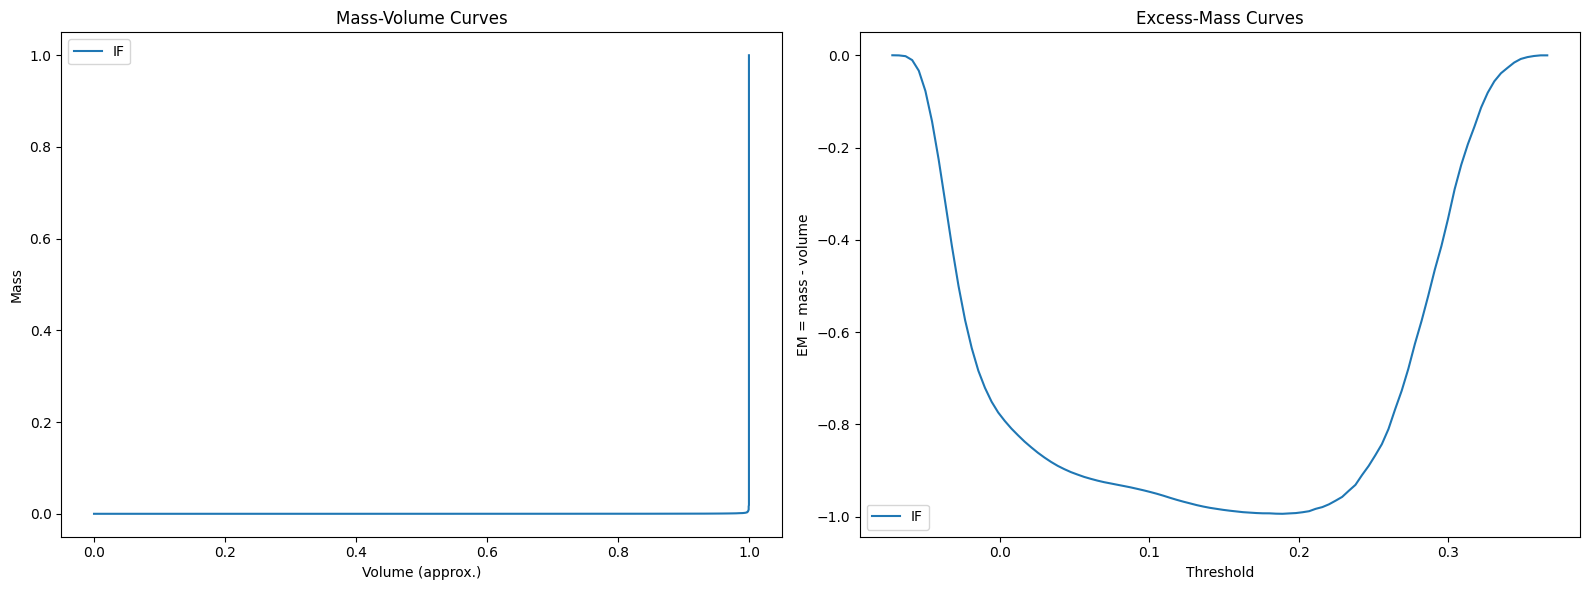

In [28]:
# Re-create the Visualizer instance with the updated class definition
viz = Visualizer(df_feat.assign(is_anomaly=df_processed['is_anomaly']))

# Access the MV/EM curves from the AnomalyDetector instance
mv_em_curves_df = ad.evaluator.mv_em_curves

# Call the plot_mv_em_curves method of the Visualizer instance
if mv_em_curves_df is not None:
    viz.plot_mv_em_curves(mv_em_curves_df)
else:
    print("MV/EM curves were not generated.")